# 1 Introduction

This notebook contains the experimental procedure in order to compare and visualize various oversampling methods on image data.

# 2 Imports

#### 2.1 General

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

#### 2.2 scikit-learn, imbalanced-learn and imbalanced-tools

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification, fetch_mldata
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.datasets import make_imbalance
from imbtools.evaluation import BinaryExperiment

# 3 Load image data

#### 3.1 Load and append datasets to container

In [3]:
datasets = []
datasets_names = ["MNIST original"]
for dataset_name in datasets_names:
    datasets.append(fetch_mldata(dataset_name, data_home="."))

#### 3.2. Binarize the target variable and make it imbalanced

In [4]:
imbalanced_datasets = []
keep_classes = [(1, 7)]
for ind, dataset in enumerate(datasets):
    X, y = dataset.data, dataset.target.astype(np.int64)
    keep_indices = (y == keep_classes[ind][0]) | (y == keep_classes[ind][1])
    X, y = X[keep_indices], label_binarize(y[keep_indices], classes=keep_classes[ind]).reshape(-1)
    imbalanced_datasets.append(make_imbalance(X, y, ratio=0.01, random_state=0))

#### 3.3 Plot samples of image data

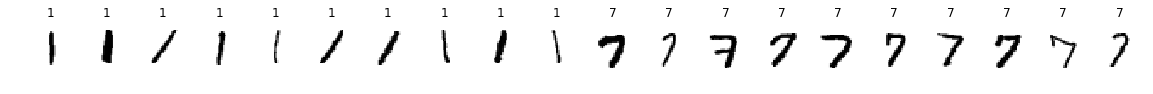

In [5]:
plt.rcParams['figure.figsize'] = (20, 20)
for dataset_ind, imbalanced_dataset in enumerate(imbalanced_datasets):
    fig, ax = plt.subplots(1, 20)
    X, y = imbalanced_dataset
    img_dim = int(sqrt(X.shape[1]))
    X = X.reshape(X.shape[0], img_dim, -1)
    majority_samples_indices = np.random.choice(np.where(y == 0)[0], size=10, replace=False)
    minority_samples_indices = np.random.choice(np.where(y == 1)[0], size=10, replace=False)
    samples_indices = np.concatenate([majority_samples_indices, minority_samples_indices])
    for ind, sample_index in enumerate(samples_indices):    
        ax[ind].imshow(X[sample_index], cmap='gray_r')
        ax[ind].axis('off')
        ax[ind].set_title(keep_classes[dataset_ind][y[sample_index]])
plt.show()

# 4 Experiment

##### 4.1 Configure experiment

In [6]:
oversampling_methods = [None, RandomOverSampler(), SMOTE()]
classifiers = [LogisticRegression()]

In [7]:
experiment = BinaryExperiment(imbalanced_datasets, classifiers, oversampling_methods)

#### 4.2 Run experiment

In [8]:
experiment.run(logging_results=False)

#### 4.3 Datasets summary

In [9]:
experiment.datasets_summary_

,Dataset name,# of features,# of instances,# of minority instances,# of majority instances,Imbalanced Ratio
0,dataset_1,784,7955,78,7877,100.99


#### 4.4 Mean CV results

In [10]:
experiment.mean_cv_results_

,Dataset,Classifier,Oversampling method,Metric,Mean CV score
0,dataset_1,LogisticRegression,None,f1 score,0.970369
1,dataset_1,LogisticRegression,None,geometric mean score,0.985543
2,dataset_1,LogisticRegression,None,roc auc score,0.999941
3,dataset_1,LogisticRegression,RandomOverSampler,f1 score,0.953281
4,dataset_1,LogisticRegression,RandomOverSampler,geometric mean score,0.988059
5,dataset_1,LogisticRegression,RandomOverSampler,roc auc score,0.999944
6,dataset_1,LogisticRegression,SMOTE,f1 score,0.947524
7,dataset_1,LogisticRegression,SMOTE,geometric mean score,0.978727
8,dataset_1,LogisticRegression,SMOTE,roc auc score,0.999815


#### 4.5 Standard deviation CV results

In [11]:
experiment.std_cv_results_

,Dataset,Classifier,Oversampling method,Metric,Std CV score
0,dataset_1,LogisticRegression,None,f1 score,0.003184
1,dataset_1,LogisticRegression,None,geometric mean score,0.002918
2,dataset_1,LogisticRegression,None,roc auc score,0.000032
3,dataset_1,LogisticRegression,RandomOverSampler,f1 score,0.003592
4,dataset_1,LogisticRegression,RandomOverSampler,geometric mean score,0.002917
5,dataset_1,LogisticRegression,RandomOverSampler,roc auc score,0.000021
6,dataset_1,LogisticRegression,SMOTE,f1 score,0.009301
7,dataset_1,LogisticRegression,SMOTE,geometric mean score,0.003016
8,dataset_1,LogisticRegression,SMOTE,roc auc score,0.000121


#### 4.6 Oversampling methods mean ranking

In [12]:
experiment.mean_ranking_results_

None  RandomOverSampler  SMOTE
Classifier         Metric                                              
LogisticRegression f1 score                 1                  2      3
                   geometric mean score     2                  1      3
                   roc auc score            2                  1      3

#### 4.7 Friedman test

In [13]:
experiment.friedman_test_results_

p-value
Classifier         Metric                        
LogisticRegression f1 score              0.367879
                   geometric mean score  0.367879
                   roc auc score         0.367879